# Import Libraries

In [1]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
!pip install -q torch-geometric

     |████████████████████████████████| 7.9 MB 21.2 MB/s 
     |████████████████████████████████| 3.5 MB 30.5 MB/s 
     |████████████████████████████████| 325 kB 21.0 MB/s 
     |████████████████████████████████| 407 kB 53.0 MB/s 
     |████████████████████████████████| 45 kB 2.9 MB/s 


In [9]:
import torch
print(torch.__version__)
print(torch.version.cuda)
import os
import numpy as np
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import normalized_mutual_info_score as nmi, adjusted_rand_score as ari
from sklearn.cluster import KMeans
import random
import warnings
warnings.filterwarnings('ignore')

import tqdm
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid, Reddit, Yelp
from torch_geometric.data import Data

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

1.10.0+cu111
11.1
cpu


# SKFR1

In [3]:
# implementing z score to normalize each feature using mean and std via torch
def zscore(x):
    '''
    zscore normalization
    '''
    # get mean and std of each feature
    mean = torch.mean(x)
    std = torch.std(x)
    # if std is not 0, then normalize each feature
    if std != 0:
        x = (x - mean) / std
    else:
        x = x - mean
    return x



In [4]:
# PyTorch Implementation of the SKFR1 algorithm
# Input: data of shape (features, samples), clusters, k (number of clusters), sparsity
# Output: center of shape (features, clusters), clusters, list_loss
def skfr1(data, clusters, k, sparsity, maxiter):
    '''
    SKFR1 algorithm
    '''
    # get number of features and samples
    features, samples = data.shape
    # criteria of shape (features)
    criteria = torch.zeros(features).to(device)

    # normalize each feature
    for i in range(features):
        data[i, :] = zscore(data[i, :])
    
    # list_loss empty list
    list_loss = []
    # number of iterations
    num_iter = 1
    switched = True

    while switched and num_iter < maxiter:
        # initialize clusters
        center = torch.zeros((features, k)).to(device)
        # members of size clusters
        members = torch.zeros(k).to(device)
        # for each sample
        for j in range(samples):
            # i as jth cluster 
            i = clusters[j]
            # add sample to center
            center[:, i] = center[:, i] + data[:, j]
            # add 1 to members
            members[i] = members[i] + 1
        # for each cluster
        for j in range(k):
            # if members is not zero
            if members[j] != 0:
                # divide by members
                center[:, j] = center[:, j] / members[j]
        # update criteria d_l
        criteria = torch.matmul(torch.mul(center, center), members.T)
        # get index from criteria
        index = torch.LongTensor([i for i in range(len(criteria))]).to(device)
        # sort criteria
        sorted_criteria = sorted(zip(criteria, index))
        J = [x[1] for x in sorted_criteria]
        # make long tensor of J
        J = torch.LongTensor(J).to(device)
        # get only features-sparsity features of J
        J = J[:features-sparsity]
        # for each J feature index
        for i in range(len(J)):
            center[J[i]] = torch.zeros(k).to(device)
        # deleter members, criteria, index, sorted_criteria, J
        del members, criteria, index, sorted_criteria, J

        # get distamce as square root of sum of square of each feature 
        distance = torch.sqrt(((data.T - center.T[:, np.newaxis])**2).sum(axis=2))
        switched = False
        # for each sample
        for i in range(samples):
            # get index of minimum distance
            j = torch.argmin(distance[:, i])
            # if this index is not same as cluster
            if j != clusters[i]:
                # update cluster
                switched = True
                clusters[i] = j
                
        # deleter distance
        del distance
        # WSS as sum of square of each feature. Initialize to zero
        WSS = torch.zeros(k).to(device)
        # for each cluster
        for cluster in range(k):
            # get temporary index where cluster is k
            temp_index = torch.LongTensor(np.where(clusters.cpu().numpy() == cluster)[0]).to(device)
            # tempX as zero tensor of shape (features, len(temp_index))
            tempX = torch.zeros(features, len(temp_index)).to(device)
            # for each temp_index
            for j in range(len(temp_index)):
                # add data to tempX
                tempX[:, j] = data[:, temp_index[j]]
            # get WSS
            WSS[cluster] = torch.mean(((tempX.T - center[:, cluster]).T)**2)
        # get loss as sum of WSS
        loss = torch.sum(WSS)
        # add loss to list_loss
        list_loss.append(loss)
        # print iteration number and loss
        print('Iteration: {} Loss: {}'.format(num_iter, loss))
        # deleter tempX, temp_index, WSS, loss
        del tempX, temp_index, WSS, loss
        # update iteration number
        num_iter += 1
    return center, clusters, list_loss


## Plotting functions

In [5]:
def plot_data(X):
    plt.scatter(
    X[:, 0], X[:, 1],
    c='white', marker='o',
    edgecolor='black', s=50
    )
    plt.show()

def plot_clusters(X,centroids,cluster):
    sns.scatterplot(X[:,0], X[:, 1], hue=cluster)
    sns.scatterplot(centroids[:,0], centroids[:, 1], s=100, color='y')
    plt.xlabel('feature1')
    plt.ylabel('feature2')
    plt.show()

def plot_loss(loss_list):
    epochs = [i for i in range(len(loss_list))]
    plt.plot(epochs,loss_list)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()

## Testing on Randomly Generated Data


Iteration: 1 Loss: 2.3721814155578613
Iteration: 2 Loss: 1.6951920986175537
Iteration: 3 Loss: 0.578973650932312
Iteration: 4 Loss: 0.35685405135154724
Iteration: 5 Loss: 0.354348748922348
Iteration: 6 Loss: 0.35441112518310547
Iteration: 7 Loss: 0.3544061779975891


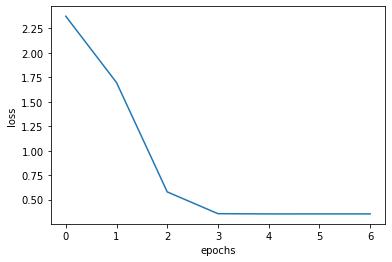

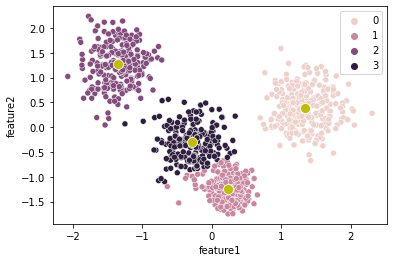

In [6]:
features = 2
cases = 1000
k = 4
sparsity = 2
X_random = np.random.normal(0,1,size=(features,cases//k))
j = 4
p = 1
for i in range(k-1):
    tmp = np.random.normal(j,2,size=(features,cases//k))
    if i%2==0:
        tmp[0] = -1*tmp[0]
    j+=4
    X_random = np.concatenate((X_random,tmp),axis=1)

X_random = torch.FloatTensor(X_random)
X_random = X_random.to(device)

Class = np.array(random.choices([i for i in range(k)],k=cases))
Class = torch.LongTensor(Class.tolist()).to(device)

centroids, cluster, loss_list = skfr1(X_random,Class,k,sparsity, 20)

plot_loss(loss_list)
plot_clusters(X_random.T.cpu(),centroids.T.cpu(),cluster.cpu())

In [7]:
# print X_random.shape
# print Class.shape
# print centroids.shape
# print cluster.shape
# print loss_list
print(f"X_random.shape: {X_random.shape}")
print(f"Class.shape: {Class.shape}")
print(f"centroids.shape: {centroids.shape}")
print(f"cluster.shape: {cluster.shape}")
print(f"loss_list: {loss_list}")

X_random.shape: torch.Size([2, 1000])
Class.shape: torch.Size([1000])
centroids.shape: torch.Size([2, 4])
cluster.shape: torch.Size([1000])
loss_list: [tensor(2.3722), tensor(1.6952), tensor(0.5790), tensor(0.3569), tensor(0.3543), tensor(0.3544), tensor(0.3544)]


# SKFR2

In [ ]:
# PyTorch Implementation of the SKFR2 algorithm
# Input: data of shape (features, samples), clusters, k (number of clusters), sparsity
# Output: center of shape (features, clusters), clusters, list_loss
def skfr2(data, clusters, k, sparsity, maxiter):
    '''
    SKFR2 algorithm
    '''
    # get number of features and samples
    features, samples = data.shape
    # criteria of shape (features)
    criteria = torch.zeros(features).to(device)

    # normalize each feature
    for i in range(features):
        data[i, :] = zscore(data[i, :])
    
    # list_loss empty list
    list_loss = []
    # number of iterations
    num_iter = 1
    switched = True

    while switched and num_iter < maxiter:
        # initialize clusters
        center = torch.zeros(features, k).to(device)
        # members of size clusters
        members = torch.zeros(k).to(device)
        # for each sample
        for j in range(samples):
            # i as jth cluster 
            i = clusters[j]
            # add sample to center
            center[:, i] = center[:, i] + data[:, j]
            # add 1 to members
            members[i] = members[i] + 1
        # for each cluster
        for j in range(k):
            # if members is not zero
            if members[j] > 0:
                # divide by members
                center[:, j] = center[:, j] / members[j]
                # Get criteria = number of members in cluster multiplied by center*center
                criteria = members[j] * torch.mul(center[:, j], center[:, j])
                # get index from criteria
                index = torch.LongTensor([i for i in range(len(criteria))]).to(device)
                # sort criteria
                sorted_criteria = sorted(zip(criteria, index))
                J = [x[1] for x in sorted_criteria]
                # make long tensor of J
                J = torch.LongTensor(J).to(device)
                # get only features-sparsity features of J
                J = J[:features-sparsity]
                for i in range(len(J)):
                    center[J[i], j] = 0
        # deleter members, criteria, index, sorted_criteria, J
        del members, criteria, index, sorted_criteria, J

        # get distamce as square root of sum of square of each feature 
        distance = torch.sqrt(((data.T - center.T[:, np.newaxis])**2).sum(axis=2))
        switched = False
        # for each sample
        for i in range(samples):
            # get index of minimum distance
            j = torch.argmin(distance[:, i])
            # if this index is not same as cluster
            if j != clusters[i]:
                # update cluster
                switched = True
                clusters[i] = j

        # deleter distance
        del distance
        # WSS as sum of square of each feature. Initialize to zero
        WSS = torch.zeros(k).to(device)
        # for each cluster
        for cluster in range(k):
            # get temporary index where cluster is k
            temp_index = torch.LongTensor(np.where(clusters.cpu().numpy() == cluster)[0]).to(device)
            # tempX as zero tensor of shape (features, len(temp_index))
            tempX = torch.zeros(features, len(temp_index)).to(device)
            # for each temp_index
            for j in range(len(temp_index)):
                # add data to tempX
                tempX[:, j] = data[:, temp_index[j]]
            # get WSS
            WSS[cluster] = torch.mean(((tempX.T - center[:, cluster]).T)**2)
        # get loss as sum of WSS
        loss = torch.sum(WSS)
        # add loss to list_loss
        list_loss.append(loss)
        # print iteration number and loss
        print('Iteration: {} Loss: {}'.format(num_iter, loss))
        # deleter tempX, temp_index, WSS, loss
        del tempX, temp_index, WSS, loss
        # update iteration number
        num_iter += 1
    return center, clusters, list_loss









Iteration: 1 Loss: 3.936830997467041
Iteration: 2 Loss: 0.5695741176605225
Iteration: 3 Loss: 0.5084350109100342
Iteration: 4 Loss: 0.49465250968933105
Iteration: 5 Loss: 0.48628509044647217
Iteration: 6 Loss: 0.4885415732860565
Iteration: 7 Loss: 0.487775981426239
Iteration: 8 Loss: 0.4872906506061554
Iteration: 9 Loss: 0.4868339002132416
Iteration: 10 Loss: 0.4859066903591156
Iteration: 11 Loss: 0.4858342111110687


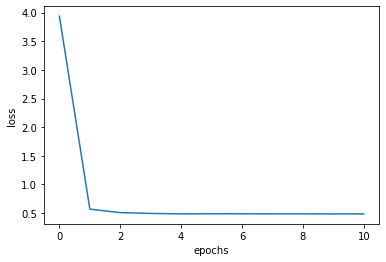

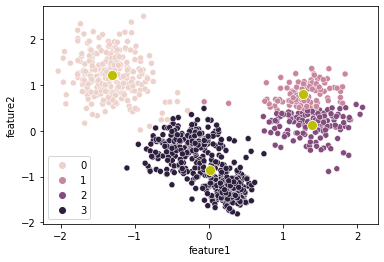

In [ ]:
features = 2
cases = 1000
k = 4
sparsity = 2
X_random = np.random.normal(0,1,size=(features,cases//k))
j = 4
p = 1
for i in range(k-1):
    tmp = np.random.normal(j,2,size=(features,cases//k))
    if i%2==0:
        tmp[0] = -1*tmp[0]
    j+=4
    X_random = np.concatenate((X_random,tmp),axis=1)

X_random = torch.FloatTensor(X_random)
X_random = X_random.to(device)

Class = np.array(random.choices([i for i in range(k)],k=cases))
Class = torch.LongTensor(Class.tolist()).to(device)

centroids, cluster, loss_list = skfr2(X_random,Class,k,sparsity, 20)

plot_loss(loss_list)
plot_clusters(X_random.T.cpu(),centroids.T.cpu(),cluster.cpu())

# Mice Protein Data

# Datasets

## Iris, Wine, Zoo, WDBC, LIBRAS, Ecoli, Wall Robot 4, Newthyroid, WarpAR10P, WarpPI10P

## [newthyroid](https://archive.ics.uci.edu/ml/datasets/Thyroid+Disease)


Iteration: 1 Loss: 2.509629964828491
Iteration: 2 Loss: 3.1078882217407227
Iteration: 3 Loss: 3.7600584030151367
Iteration: 4 Loss: 3.5271143913269043
Iteration: 5 Loss: 3.152592182159424
Iteration: 6 Loss: 2.9749059677124023
Iteration: 7 Loss: 2.7862627506256104
Iteration: 8 Loss: 2.7528693675994873
Iteration: 9 Loss: 2.722163200378418
Iteration: 10 Loss: 2.722106695175171


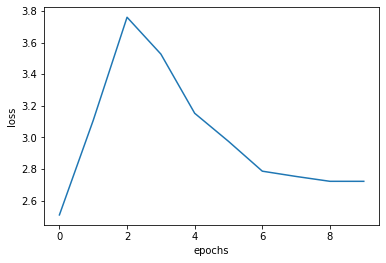

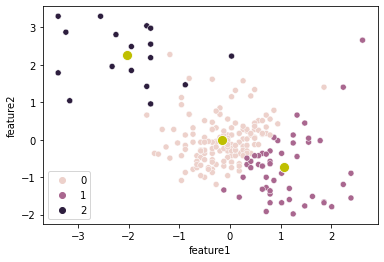

In [21]:
root = 'data'
folder = 'thyroid'
filename = 'new-thyroid.data'
# read filename
data = pd.read_csv(os.path.join(root, folder, filename), header=None)
data.head()

k = 3 # number of clusters
sparsity = 3 # sparsity

# store the first column of data as label and then drop it
label = data.iloc[:, 0].values
data = data.drop(data.columns[0], axis=1)

# get the number of features and cases
features = data.shape[1]
cases = data.shape[0]

# convert data to numpy array
data = data.values
# transpose data
data = data.T

X_random = torch.FloatTensor(data)
X_random = X_random.to(device)

Class = np.array(random.choices([i for i in range(k)],k=cases))
Class = torch.LongTensor(Class.tolist()).to(device)

centroids, cluster, loss_list = skfr1(X_random,Class,k,sparsity, 50)

plot_loss(loss_list)
plot_clusters(X_random.T.cpu(),centroids.T.cpu(),cluster.cpu())

## [Iris](https://archive.ics.uci.edu/ml/datasets/iris)

Iteration: 1 Loss: 2.41880464553833
Iteration: 2 Loss: 0.8119252920150757
Iteration: 3 Loss: 0.7056077718734741
Iteration: 4 Loss: 0.7049742937088013
Iteration: 5 Loss: 0.7046844959259033


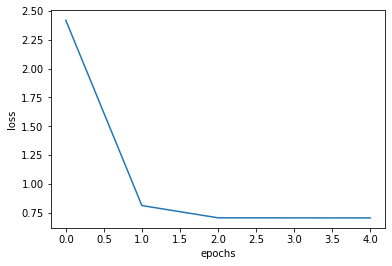

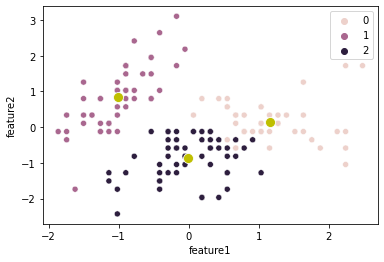

In [33]:
root = 'data'
folder = 'iris'
filename = 'iris.data'
# read filename
data = pd.read_csv(os.path.join(root, folder, filename), header=None)
data.head()

k = 3 # number of clusters
sparsity = 4 # sparsity

# store the last column of data as label and then drop it
label = data.iloc[:, 4].values
data = data.drop(data.columns[4], axis=1)

# get the number of features and cases
features = data.shape[1]
cases = data.shape[0]

# convert data to numpy array
data = data.values
# transpose data
data = data.T

X_random = torch.FloatTensor(data)
X_random = X_random.to(device)

Class = np.array(random.choices([i for i in range(k)],k=cases))
Class = torch.LongTensor(Class.tolist()).to(device)

centroids, cluster, loss_list = skfr1(X_random,Class,k,sparsity, 20)

plot_loss(loss_list)
plot_clusters(X_random.T.cpu(),centroids.T.cpu(),cluster.cpu())

In [34]:
# get number of unique values from cluster torch and store in dictionary
unique_cluster = {}
for i in range(cases):
    if cluster[i].item() not in unique_cluster:
        unique_cluster[cluster[i].item()] = 1
    else:
        unique_cluster[cluster[i].item()] += 1
unique_cluster

{0: 44, 1: 50, 2: 56}

## [Wine](https://archive.ics.uci.edu/ml/datasets/wine)

Iteration: 1 Loss: 2.7928709983825684
Iteration: 2 Loss: 1.883195161819458
Iteration: 3 Loss: 1.791100025177002
Iteration: 4 Loss: 1.758786916732788
Iteration: 5 Loss: 1.757136344909668


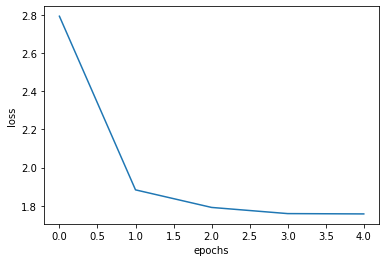

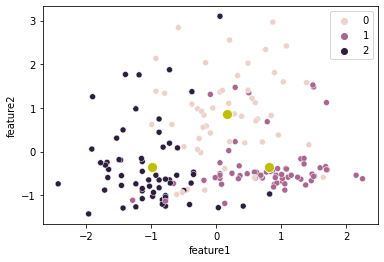

In [38]:
root = 'data'
folder = 'wine'
filename = 'wine.data'
# read filename
data = pd.read_csv(os.path.join(root, folder, filename), header=None)
data.head()

k = 3 # number of clusters
sparsity = 10 # sparsity

# store the first column of data as label and then drop it
label = data.iloc[:, 0].values
data = data.drop(data.columns[0], axis=1)

# get the number of features and cases
features = data.shape[1]
cases = data.shape[0]

# convert data to numpy array
data = data.values
# transpose data
data = data.T

X_random = torch.FloatTensor(data)
X_random = X_random.to(device)

Class = np.array(random.choices([i for i in range(k)],k=cases))
Class = torch.LongTensor(Class.tolist()).to(device)

centroids, cluster, loss_list = skfr1(X_random,Class,k,sparsity, 20)

plot_loss(loss_list)
plot_clusters(X_random.T.cpu(),centroids.T.cpu(),cluster.cpu())

## [Zoo](https://archive.ics.uci.edu/ml/datasets/zoo)

Iteration: 1 Loss: 5.3104753494262695
Iteration: 2 Loss: 2.936229705810547
Iteration: 3 Loss: 2.6176247596740723


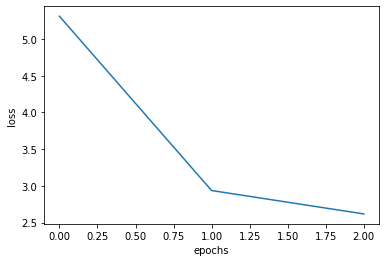

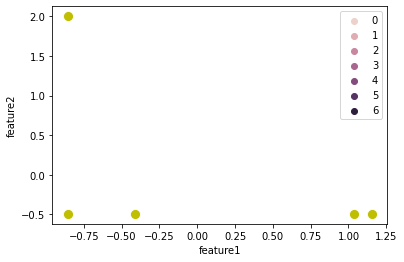

In [42]:
root = 'data'
folder = 'zoo'
filename = 'zoo.data'
# read filename
data = pd.read_csv(os.path.join(root, folder, filename), header=None)
data.head()

k = 7 # number of clusters
sparsity = 13 # sparsity

# store the first column of data as label and then drop it
label = data.iloc[:, 0].values
data = data.drop(data.columns[0], axis=1)

# get the number of features and cases
features = data.shape[1]
cases = data.shape[0]

# convert data to numpy array
data = data.values
# transpose data
data = data.T

X_random = torch.FloatTensor(data)
X_random = X_random.to(device)

Class = np.array(random.choices([i for i in range(k)],k=cases))
Class = torch.LongTensor(Class.tolist()).to(device)

centroids, cluster, loss_list = skfr1(X_random,Class,k,sparsity, 20)

plot_loss(loss_list)
plot_clusters(X_random.T.cpu(),centroids.T.cpu(),cluster.cpu())


## [WDBC](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic))

Iteration: 1 Loss: 2.1386263370513916
Iteration: 2 Loss: 1.5762314796447754
Iteration: 3 Loss: 1.5720447301864624
Iteration: 4 Loss: 1.5738705396652222
Iteration: 5 Loss: 1.573846697807312


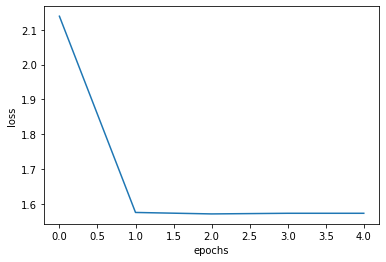

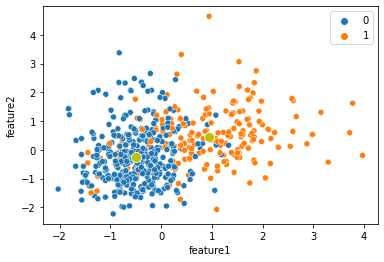

In [44]:
root = 'data'
folder = 'wdbc'
filename = 'wdbc.data'
# read filename
data = pd.read_csv(os.path.join(root, folder, filename), header=None)
data.head()

k = 2 # number of clusters
sparsity = 28 # sparsity

# store the second column of data as label and then drop it
label = data.iloc[:, 1].values
data = data.drop(data.columns[1], axis=1)

# drop the first column since it's id
data = data.drop(data.columns[0], axis=1)

# get the number of features and cases
features = data.shape[1]
cases = data.shape[0]

# convert data to numpy array
data = data.values
# transpose data
data = data.T

X_random = torch.FloatTensor(data)
X_random = X_random.to(device)

Class = np.array(random.choices([i for i in range(k)],k=cases))
Class = torch.LongTensor(Class.tolist()).to(device)

centroids, cluster, loss_list = skfr1(X_random,Class,k,sparsity, 20)

plot_loss(loss_list)
plot_clusters(X_random.T.cpu(),centroids.T.cpu(),cluster.cpu())


## [Libras](https://archive.ics.uci.edu/ml/datasets/Libras+Movement)

Iteration: 1 Loss: 11.634130477905273
Iteration: 2 Loss: 7.604501724243164
Iteration: 3 Loss: 6.336916923522949
Iteration: 4 Loss: 5.791234970092773
Iteration: 5 Loss: 5.597042083740234
Iteration: 6 Loss: 5.5421881675720215
Iteration: 7 Loss: 5.476536273956299
Iteration: 8 Loss: 5.4357709884643555
Iteration: 9 Loss: 5.4409003257751465
Iteration: 10 Loss: 5.430270195007324


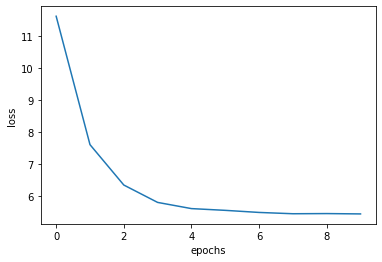

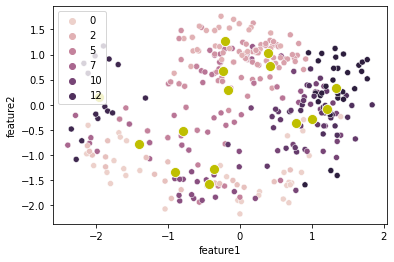

In [47]:
root = 'data'
folder = 'libras'
filename = 'movement_libras.data'
# read filename
data = pd.read_csv(os.path.join(root, folder, filename), header=None)
data.head()

k = 15 # number of clusters
sparsity = 85 # sparsity

# store the last column of data as label and then drop it
label = data.iloc[:, 90].values
data = data.drop(data.columns[90], axis=1)

# get the number of features and cases
features = data.shape[1]
cases = data.shape[0]

# convert data to numpy array
data = data.values
# transpose data
data = data.T

X_random = torch.FloatTensor(data)
X_random = X_random.to(device)

Class = np.array(random.choices([i for i in range(k)],k=cases))
Class = torch.LongTensor(Class.tolist()).to(device)

centroids, cluster, loss_list = skfr1(X_random,Class,k,sparsity, 20)

plot_loss(loss_list)
plot_clusters(X_random.T.cpu(),centroids.T.cpu(),cluster.cpu())


## [Mice Protein Data](https://archive.ics.uci.edu/ml/datasets/Mice+Protein+Expression)

In [58]:
root = 'data'
folder = 'mice_protein'
filename = 'Data_Cortex_Nuclear.xls'
# read filename with first row as header
data = pd.read_excel(os.path.join(root, folder, filename), header=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MouseID          1080 non-null   object 
 1   DYRK1A_N         1077 non-null   float64
 2   ITSN1_N          1077 non-null   float64
 3   BDNF_N           1077 non-null   float64
 4   NR1_N            1077 non-null   float64
 5   NR2A_N           1077 non-null   float64
 6   pAKT_N           1077 non-null   float64
 7   pBRAF_N          1077 non-null   float64
 8   pCAMKII_N        1077 non-null   float64
 9   pCREB_N          1077 non-null   float64
 10  pELK_N           1077 non-null   float64
 11  pERK_N           1077 non-null   float64
 12  pJNK_N           1077 non-null   float64
 13  PKCA_N           1077 non-null   float64
 14  pMEK_N           1077 non-null   float64
 15  pNR1_N           1077 non-null   float64
 16  pNR2A_N          1077 non-null   float64
 17  pNR2B_N       

Iteration: 1 Loss: 6.931678295135498
Iteration: 2 Loss: 4.944891929626465
Iteration: 3 Loss: 4.571222305297852
Iteration: 4 Loss: 4.453022003173828
Iteration: 5 Loss: 4.432397365570068
Iteration: 6 Loss: 4.434660911560059
Iteration: 7 Loss: 4.435126304626465
Iteration: 8 Loss: 4.436473369598389
Iteration: 9 Loss: 4.432035446166992
Iteration: 10 Loss: 4.42922830581665
Iteration: 11 Loss: 4.41702938079834
Iteration: 12 Loss: 4.416400909423828
Iteration: 13 Loss: 4.421523094177246
Iteration: 14 Loss: 4.425353527069092
Iteration: 15 Loss: 4.418487548828125
Iteration: 16 Loss: 4.410994052886963
Iteration: 17 Loss: 4.410728931427002


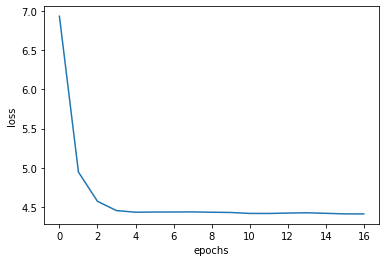

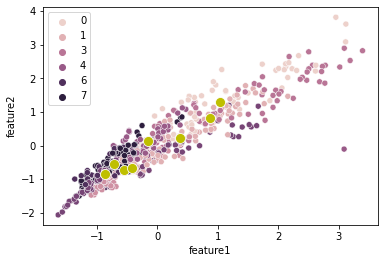

In [61]:
root = 'data'
folder = 'mice_protein'
filename = 'Data_Cortex_Nuclear.xls'
# read filename with first row as header
data = pd.read_excel(os.path.join(root, folder, filename), header=0)
data.head()

# drop the columns named as MouseID, BCL2_N from the data
for col in data.columns:
    if 'MouseID' in col:
        del data[col]
    if 'BCL2_N' in col:
        del data[col]

data.head()

# Convert Genotype column from categorical ('Control', 'Ts65Dn) to numeric
data['Genotype'] = data['Genotype'].map({'Control': 0, 'Ts65Dn': 1})

# Convert Treatment column from categorical ('Memantine', 'Saline') to numeric
data['Treatment'] = data['Treatment'].map({'Memantine': 0, 'Saline': 1})

# Convert Behavior column from categorical ('C/S', 'S/C') to numeric
data['Behavior'] = data['Behavior'].map({'C/S': 0, 'S/C': 1})

# store the class column as label and then drop it
label = data.iloc[:, -1].values
data = data.drop(data.columns[-1], axis=1)

# drop null values
data = data.dropna()

# data.info()

k = 8 # number of clusters
sparsity = 75 # sparsity


# get the number of features and cases
features = data.shape[1]
cases = data.shape[0]

# convert data to numpy array
data = data.values
# transpose data
data = data.T

X_random = torch.FloatTensor(data)
X_random = X_random.to(device)

Class = np.array(random.choices([i for i in range(k)],k=cases))
Class = torch.LongTensor(Class.tolist()).to(device)

centroids, cluster, loss_list = skfr1(X_random,Class,k,sparsity, 20)

plot_loss(loss_list)
plot_clusters(X_random.T.cpu(),centroids.T.cpu(),cluster.cpu())


## [Ecoli](https://archive.ics.uci.edu/ml/datasets/ecoli)

Iteration: 1 Loss: 7.345681667327881
Iteration: 2 Loss: 5.308162689208984
Iteration: 3 Loss: 5.018671035766602
Iteration: 4 Loss: 4.820472717285156
Iteration: 5 Loss: 4.8405070304870605
Iteration: 6 Loss: 4.731007099151611
Iteration: 7 Loss: 4.7123870849609375
Iteration: 8 Loss: 5.609192848205566
Iteration: 9 Loss: 5.354457378387451
Iteration: 10 Loss: 4.809053421020508
Iteration: 11 Loss: 4.670596122741699
Iteration: 12 Loss: 4.606847763061523
Iteration: 13 Loss: 4.549700736999512
Iteration: 14 Loss: 4.588999271392822
Iteration: 15 Loss: 4.588047981262207


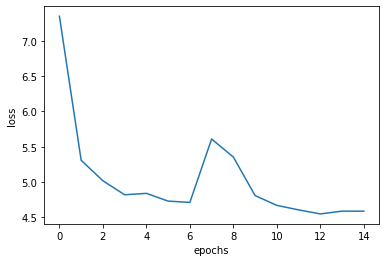

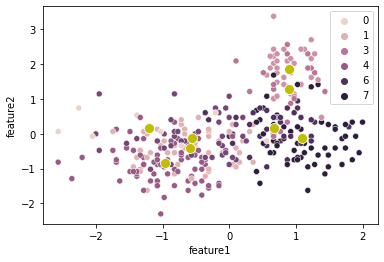

In [70]:
root = 'data'
folder = 'ecoli'
filename = 'ecoli.data'
# read filename with space as delimiter
data = pd.read_csv(os.path.join(root, folder, filename), delim_whitespace=True)
data.head()

k = 8 # number of clusters
sparsity = 5 # sparsity

# store the last column of data as label and then drop it
label = data.iloc[:, -1].values
data = data.drop(data.columns[-1], axis=1)

# drop the first column since it's expression
data = data.drop(data.columns[0], axis=1)
data.head()

# get the number of features and cases
features = data.shape[1]
cases = data.shape[0]

# convert data to numpy array
data = data.values
# transpose data
data = data.T

X_random = torch.FloatTensor(data)
X_random = X_random.to(device)

Class = np.array(random.choices([i for i in range(k)],k=cases))
Class = torch.LongTensor(Class.tolist()).to(device)

centroids, cluster, loss_list = skfr1(X_random,Class,k,sparsity, 20)

plot_loss(loss_list)
plot_clusters(X_random.T.cpu(),centroids.T.cpu(),cluster.cpu())


## Robot4

Iteration: 1 Loss: 3.9816150665283203
Iteration: 2 Loss: 3.3200292587280273
Iteration: 3 Loss: 3.1923863887786865
Iteration: 4 Loss: 3.106170177459717
Iteration: 5 Loss: 3.1118242740631104
Iteration: 6 Loss: 3.131002902984619
Iteration: 7 Loss: 3.13713002204895
Iteration: 8 Loss: 3.1243016719818115
Iteration: 9 Loss: 3.1192924976348877
Iteration: 10 Loss: 3.114611864089966
Iteration: 11 Loss: 3.1135969161987305
Iteration: 12 Loss: 3.1144063472747803
Iteration: 13 Loss: 3.1147513389587402
Iteration: 14 Loss: 3.114863395690918
Iteration: 15 Loss: 3.1147849559783936
Iteration: 16 Loss: 3.1144182682037354
Iteration: 17 Loss: 3.114377737045288
Iteration: 18 Loss: 3.114470958709717
Iteration: 19 Loss: 3.114574909210205


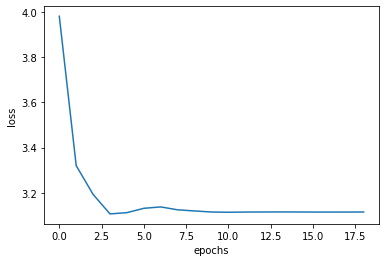

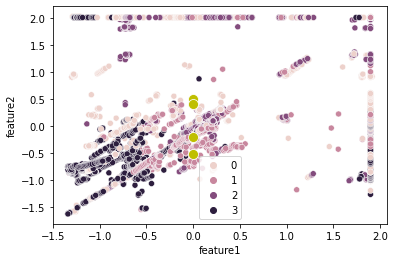

In [74]:
root = 'data'
folder = 'robot4'
filename = 'sensor_readings_24.data'
# read filename with comma as delimiter and header as none
data = pd.read_csv(os.path.join(root, folder, filename), delimiter=',', header=None)
data.head()
 
k = 4 # number of clusters
sparsity = 20 # sparsity

# store the last column of data as label and then drop it
label = data.iloc[:, -1].values
data = data.drop(data.columns[-1], axis=1)

# drop the first column since it's expression
data = data.drop(data.columns[0], axis=1)
data.head()

# get the number of features and cases
features = data.shape[1]
cases = data.shape[0]

# convert data to numpy array
data = data.values
# transpose data
data = data.T

X_random = torch.FloatTensor(data)
X_random = X_random.to(device)

Class = np.array(random.choices([i for i in range(k)],k=cases))
Class = torch.LongTensor(Class.tolist()).to(device)

centroids, cluster, loss_list = skfr1(X_random,Class,k,sparsity, 20)

plot_loss(loss_list)
plot_clusters(X_random.T.cpu(),centroids.T.cpu(),cluster.cpu())


In [65]:
data['AAT_ECOLI'].unique()

array(['ACEA_ECOLI', 'ACEK_ECOLI', 'ACKA_ECOLI', 'ADI_ECOLI',
       'ALKH_ECOLI', 'AMPD_ECOLI', 'AMY2_ECOLI', 'APT_ECOLI',
       'ARAC_ECOLI', 'ASG1_ECOLI', 'BTUR_ECOLI', 'CAFA_ECOLI',
       'CAIB_ECOLI', 'CFA_ECOLI', 'CHEA_ECOLI', 'CHEB_ECOLI',
       'CHEW_ECOLI', 'CHEY_ECOLI', 'CHEZ_ECOLI', 'CRL_ECOLI',
       'CSPA_ECOLI', 'CYNR_ECOLI', 'CYPB_ECOLI', 'CYPC_ECOLI',
       'CYSB_ECOLI', 'CYSE_ECOLI', 'DAPD_ECOLI', 'DCP_ECOLI',
       'DDLA_ECOLI', 'DDLB_ECOLI', 'DEOC_ECOLI', 'DLDH_ECOLI',
       'EFG_ECOLI', 'EFTS_ECOLI', 'EFTU_ECOLI', 'ENO_ECOLI', 'FABB_ECOLI',
       'FES_ECOLI', 'G3P1_ECOLI', 'G3P2_ECOLI', 'G6PI_ECOLI',
       'GCVA_ECOLI', 'GLNA_ECOLI', 'GLPD_ECOLI', 'GLYA_ECOLI',
       'GSHR_ECOLI', 'GT_ECOLI', 'HEM6_ECOLI', 'HEMN_ECOLI', 'HPRT_ECOLI',
       'IF1_ECOLI', 'IF2_ECOLI', 'ILVY_ECOLI', 'IPYR_ECOLI', 'KAD_ECOLI',
       'KDSA_ECOLI', 'LEU3_ECOLI', 'LON_ECOLI', 'LPLA_ECOLI',
       'LYSR_ECOLI', 'MALQ_ECOLI', 'MALZ_ECOLI', 'MASY_ECOLI',
       'METB_ECOLI', 'METC_

In [57]:
data.info()

AttributeError: ignored

In [53]:
data['Behavior'].unique()

array(['C/S', 'S/C'], dtype=object)

In [40]:
data[0].unique()

array(['aardvark', 'antelope', 'bass', 'bear', 'boar', 'buffalo', 'calf',
       'carp', 'catfish', 'cavy', 'cheetah', 'chicken', 'chub', 'clam',
       'crab', 'crayfish', 'crow', 'deer', 'dogfish', 'dolphin', 'dove',
       'duck', 'elephant', 'flamingo', 'flea', 'frog', 'fruitbat',
       'giraffe', 'girl', 'gnat', 'goat', 'gorilla', 'gull', 'haddock',
       'hamster', 'hare', 'hawk', 'herring', 'honeybee', 'housefly',
       'kiwi', 'ladybird', 'lark', 'leopard', 'lion', 'lobster', 'lynx',
       'mink', 'mole', 'mongoose', 'moth', 'newt', 'octopus', 'opossum',
       'oryx', 'ostrich', 'parakeet', 'penguin', 'pheasant', 'pike',
       'piranha', 'pitviper', 'platypus', 'polecat', 'pony', 'porpoise',
       'puma', 'pussycat', 'raccoon', 'reindeer', 'rhea', 'scorpion',
       'seahorse', 'seal', 'sealion', 'seasnake', 'seawasp', 'skimmer',
       'skua', 'slowworm', 'slug', 'sole', 'sparrow', 'squirrel',
       'starfish', 'stingray', 'swan', 'termite', 'toad', 'tortoise',
       

In [ ]:
# function to get normalized mutual information
def get_nmi(data, clusters, k):
    '''
    Get normalized mutual information
    '''
    # get number of features and samples
    features, samples = data.shape
    # initialize nmi
    nmi = 0
    # for each sample
    for i in range(samples):
        # get cluster of sample
        j = clusters[i]
        # get index of cluster
        index = torch.LongTensor([i for i in range(len(clusters))]).to(device)
        # get index of cluster
        index = index[clusters == j]
        # get data of cluster
        tempX = data[:, index]
        # get mean of cluster
        mean = torch.mean(tempX, axis=1)
        # get distance of sample to mean
        distance = torch.sqrt(((data[:, i].T - mean)**2).sum(axis=1))
        # get minimum distance
        min_distance = torch.min(distance)
        # get maximum distance
        max_distance = torch.max(distance)
        # get normalized distance
        normalized_distance = (distance - min_distance) / (max_distance - min_distance)
        # get nmi
        nmi += torch.log(normalized_distance)
    # divide by samples
    nmi = nmi / samples
    # return nmi
    return nmi